# Keras Neural Network Models

## Set up and Preprocessing
Import relevant packages and download the dataset from Kaggle. Unzip the data, create a directory on the Google VM's Linux server, and save the data there.

In [0]:
import json, os, zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from google.colab import files

Using TensorFlow backend.


In [0]:
api_token = ... #REDACTED
!mkdir ~/.kaggle
!cd ~/.kaggle
!touch kaggle.json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!mkdir content
!kaggle datasets download rouzbehm/jigsawdataset -p content
!ls content


os.chdir('content')
for file in os.listdir():
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

100% 48.9M/48.9M [00:02<00:00, 21.1MB/s]

jigsawdataset.zip


In [0]:
!ls

data.csv  jigsawdataset.zip


## Data Preprocessing
Split the data into train, test, and validation sets, with the 90:5:5 allocation. Then use the Keras Tokenizer to generate a dictionary consisting of each word in the dataset (in lower case), after removing the following characters: !"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n. The tokenizer replaces each word in each sentence with an integer that is the index in the dictionary. Finally, pad the ends of each sentence with 0s such that each sentence has the same length.

In [0]:
data = pd.read_csv("data.csv")
X_train_raw, X_test_raw, y_train, y_test = train_test_split(data["comment_text"], data["unsafe"], test_size = 0.1, random_state = 123)
X_test_raw, X_validation_raw, y_test, y_validation = train_test_split(X_test_raw, y_test, test_size = 0.5, random_state = 123)

max_len = max(len(x.split()) for x in data["comment_text"]) #length of longest sentence

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_raw)

X_train_tokenized = tokenizer.texts_to_sequences(X_train_raw)
X_test_tokenized = tokenizer.texts_to_sequences(X_test_raw)
X_validation_tokenized = tokenizer.texts_to_sequences(X_validation_raw)

X_train = pad_sequences(X_train_tokenized, padding='post', maxlen = max_len)
X_test = pad_sequences(X_test_tokenized, padding='post', maxlen = max_len)
X_validation = pad_sequences(X_validation_tokenized, padding='post', maxlen = max_len)

Define methods to calculate the accuracy, precision, and recall, and plot the validation loss and accuracy against the training loss and accuracy

In [0]:
def accuracy(actual, prediction):
  correct = sum([x == y for x,y in zip(actual, prediction)])
  total = prediction.shape[0]
  return correct / total

def precision(actual, prediction, class_of_interest):
  correct = sum([x == y and x == class_of_interest for x,y in zip(actual, prediction)])
  total = list(prediction).count(class_of_interest)
  return correct / total

def recall(actual, prediction, class_of_interest):
  correct = sum([x == y and x == class_of_interest for x,y in zip(actual, prediction)])
  total = list(actual).count(class_of_interest)
  return correct / total

def plot_metrics(history, num_epochs):
  plt.plot(list(range(1,num_epochs+1)), history.history['acc'],
           list(range(1,num_epochs+1)), history.history['val_acc'])
  plt.title("Accuracy Curves")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Accuracy")
  plt.show()

  plt.plot(list(range(1,num_epochs+1)), history.history['loss'],
           list(range(1,num_epochs+1)), history.history['val_loss'])
  plt.title("Loss Curves")
  plt.xlabel("Number of Epochs")
  plt.ylabel("Loss curves")
  plt.show()

## Model 0: Simple Feed-Forward Neural Network

Create the baseline Keras model. It is a sequential model with the following structure:
- Embedding layer that converts each integer sequence (previously a sentence) into a dense vector, which is easier for the model to use.
- Flattening layer to convert the matrix of values to a single vector
- Dense layer with 1 output neuron and sigmoid activation to classify each sentence as either safe or unsafe

The best optimizer was found to be Adam, and the best learning rate was found to be 0.0001. These were used in all subsequent models.

Train the model for up to 10 epochs, with early stopping (patience of 1). Plot the accuracy and loss curves (training vs validation), and print the accuracy, precision, and recall.

In [0]:
model0 = Sequential()
model0.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length = max_len))
model0.add(Flatten())
model0.add(Dense(1, activation = "sigmoid"))

model0.compile(optimizer = optimizers.Adam(lr=0.0001), 
                loss = 'binary_crossentropy', 
                metrics = ['accuracy'])

model0.summary()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2321, 128)         24291328  
_________________________________________________________________
flatten_1 (Flatten)          (None, 297088)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 297089    
Total params: 24,588,417
Trainable params: 24,588,417
Non-trainable params: 0
_________________________________________________________________





Train on 328050 samples, validate on 18225 samples
Epoch 1/10





328050/328050 [==============================] - 139s 425us/step - loss: 0.5527 - acc: 0.7177 - val_loss: 0.4189 - val_acc: 0.8273
Epoch 2/10
328050/328050 [==============================] - 132s 402us/step - loss: 0.3607 - acc: 0.8548 - val_loss: 0.3483 - val_acc: 0.8584
Epoch 3/10
328050/328050 [==============================] - 129s 395us/step - loss: 0.3053 - acc: 0.8789 - val_loss: 0.3315 - val_acc: 0.8652
Epoch 4/10
328050/328050 [==============================] - 129s 394us/step - loss: 0.2794 - acc: 0.8907 - val_loss: 0.3265 - val_acc: 0.8721
Epoch 5/10
328050/328050 [==============================] - 129s 394us/step - loss: 0.2617 - acc: 0.8986 - val_loss: 0.3265 - val_acc: 0.8708


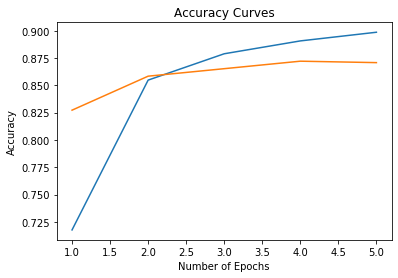

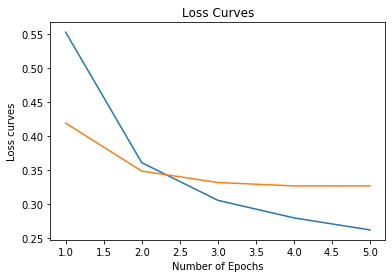

In [0]:
model0_history = model0.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation),
                            batch_size=128, use_multiprocessing=True, callbacks = [EarlyStopping(monitor='val_loss', patience=1)])
plot_metrics(model0_history, len(model0_history.history["val_loss"]))

In [0]:
y_pred0 = np.round(model0.predict(X_test))
print("Accuracy", accuracy(y_test, y_pred0))
print("Precision (Safe)", precision(y_test, y_pred0, 0))
print("Precision (Unsafe)", precision(y_test, y_pred0, 1))
print("Recall (Safe)", recall(y_test, y_pred0, 0))
print("Recall (Unsafe)", recall(y_test, y_pred0, 1))


Accuracy [0.86737997]
Precision (Safe) [0.84751883]
Precision (Unsafe) [0.88994374]
Recall (Safe) [0.89742189]
Recall (Unsafe) [0.83706317]


## Model 1: Feed-Forward Neural Network with Extra Dense Layer

Create a more refined version of the baseline Keras model. It is a sequential model with the following structure:
- Embedding layer that converts each integer sequence (previously a sentence) into a dense vector, which is easier for the model to use.
- Flattening layer to convert the matrix of values to a single vector
- Dense layer with 256 output neurons and relu activation as an intermediate neural network
- Dense layer with 1 output neuron and sigmoid activation to classify each sentence as either safe or unsafe

Train the model for up to 10 epochs, with early stopping (patience of 1). Plot the accuracy and loss curves (training vs validation), and print the accuracy, precision, and recall.

In [0]:
model1 = Sequential()
model1.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length = max_len))
model1.add(Flatten())
model1.add(Dense(256, activation = "relu"))
model1.add(Dense(1, activation = "sigmoid"))

model1.compile(optimizer = optimizers.Adam(lr=0.0001), 
                loss = 'binary_crossentropy', 
                metrics = ['accuracy'])

model1.summary()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2321, 128)         24291328  
_________________________________________________________________
flatten_1 (Flatten)          (None, 297088)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               76054784  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 100,346,369
Trainable params: 100,346,369
Non-trainable params: 0
_________________________________________________________________


Train the model with maximum of ten epochs, with early stopping base on the validation loss. If the validation loss does not improve after 2 epochs, stop training the model. Plot the training loss against the validation loss, and the training accuracy against the validation accuracy.




Train on 328050 samples, validate on 18225 samples
Epoch 1/10





328050/328050 [==============================] - 173s 526us/step - loss: 0.5255 - acc: 0.7286 - val_loss: 0.3830 - val_acc: 0.8343
Epoch 2/10
328050/328050 [==============================] - 166s 505us/step - loss: 0.3231 - acc: 0.8669 - val_loss: 0.3224 - val_acc: 0.8733
Epoch 3/10
328050/328050 [==============================] - 166s 505us/step - loss: 0.2677 - acc: 0.8916 - val_loss: 0.3124 - val_acc: 0.8716
Epoch 4/10
328050/328050 [==============================] - 166s 506us/step - loss: 0.2371 - acc: 0.9060 - val_loss: 0.3027 - val_acc: 0.8829
Epoch 5/10
328050/328050 [==============================] - 166s 505us/step - loss: 0.2141 - acc: 0.9170 - val_loss: 0.3065 - val_acc: 0.8791


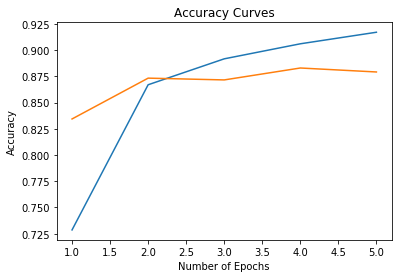

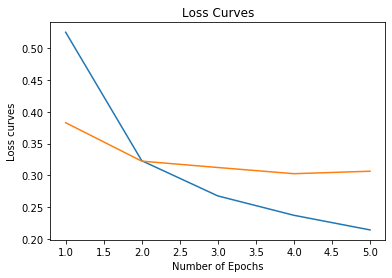

In [0]:
model1_history = model1.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation),
                            batch_size=128, use_multiprocessing=True, callbacks = [EarlyStopping(monitor='val_loss', patience=1)])
plot_metrics(model1_history, len(model1_history.history["val_loss"]))

Test the trained model on the test set. Print the accuracy, as well as the recall and precision for both classes.

In [0]:
y_pred1 = np.round(model1.predict(X_test))
print("Accuracy", accuracy(y_test, y_pred1))
print("Precision (Safe)", precision(y_test, y_pred1, 0))
print("Precision (Unsafe)", precision(y_test, y_pred1, 1))
print("Recall (Safe)", recall(y_test, y_pred1, 0))
print("Recall (Unsafe)", recall(y_test, y_pred1, 1))


Accuracy [0.87572016]
Precision (Safe) [0.89469463]
Precision (Unsafe) [0.85828595]
Recall (Safe) [0.85296045]
Recall (Unsafe) [0.89868813]


## Model 2: Convolutional Neural Network with One Convolutional Layer

Create the first variation of the CNN. It is a sequential model with the following structure:
- Embedding layer that converts each integer sequence (previously a sentence) into a dense vector, which is easier for the model to use.
- One-Dimensional Convolutional layer with 32 filters, filter size of 3, and relu activation
- One-Dimensional Maximum Pooling layer
- Flattening layer to convert the matrix of values to a single vector
- Dense layer with 1 output neuron and sigmoid activation to classify each sentence as either safe or unsafe

The pool size was varied between 3 and 5, and it was found to have negligible impact, and thus 3 was chosen. Convolutional filter variations of 16, 32, 64, and 128 were explored. Ultimately, 32 filters provided the best result. This is the model that is shown.

Train the model for up to 10 epochs, with early stopping (patience of 1). Plot the accuracy and loss curves (training vs validation), and print the accuracy, precision, and recall.



In [0]:
model2_32 = Sequential()

model2_32.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length = max_len))
model2_32.add(Conv1D(32, 3, activation = "relu"))
model2_32.add(MaxPooling1D())

model2_32.add(Flatten())
model2_32.add(Dense(256, activation = "relu"))
model2_32.add(Dense(1, activation = "sigmoid"))

model2_32.compile(optimizer = optimizers.Adam(lr=0.0001), 
               loss = 'binary_crossentropy', 
               metrics = ['accuracy'])

model2_32.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2321, 128)         24291328  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2319, 32)          12320     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1159, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 37088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               9494784   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 33,798,689
Trainable params: 33,798,689
Non-trainable params: 0
_________________________________________

Train the model, with early stopping based on the validation loss with a patience of two. Plot the training loss against the validation loss, and the training accuracy against the validation accuracy.

Train on 328050 samples, validate on 18225 samples
Epoch 1/10
328050/328050 [==============================] - 105s 320us/step - loss: 0.4140 - acc: 0.7933 - val_loss: 0.2919 - val_acc: 0.8816
Epoch 2/10
328050/328050 [==============================] - 102s 310us/step - loss: 0.2536 - acc: 0.8972 - val_loss: 0.2700 - val_acc: 0.8906
Epoch 3/10
328050/328050 [==============================] - 101s 309us/step - loss: 0.2236 - acc: 0.9108 - val_loss: 0.2769 - val_acc: 0.8882


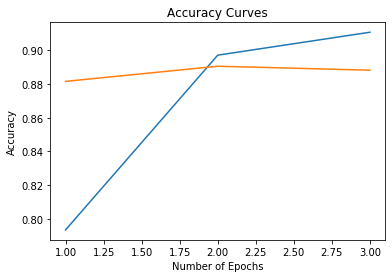

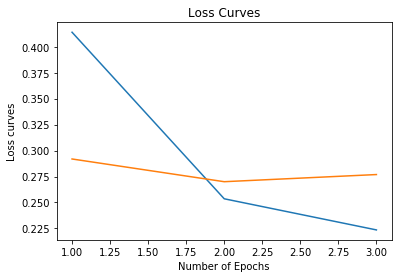

In [0]:
model2_32_history = model2_32.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation), 
                            batch_size=128, use_multiprocessing=True, callbacks = [EarlyStopping(monitor='val_loss', patience=1)])
plot_metrics(model2_32_history, len(model2_32_history.history["val_loss"]))

Test the model on the test set, and print out the accuracy as well as the recall and precision for both classes.

In [0]:
y_pred2_32 = np.round(model2_32.predict(X_test))
print("Accuracy", accuracy(y_test, y_pred2_32))
print("Precision (Safe)", precision(y_test, y_pred2_32, 0))
print("Precision (Unsafe)", precision(y_test, y_pred2_32, 1))
print("Recall (Safe)", recall(y_test, y_pred2_32, 0))
print("Recall (Unsafe)", recall(y_test, y_pred2_32, 1))


Accuracy [0.88888889]
Precision (Safe) [0.90975974]
Precision (Unsafe) [0.86982994]
Recall (Safe) [0.86454009]
Recall (Unsafe) [0.91346048]


## Model 3: Convolutional Neural Network with Two Convolutional Layers

Create the second variation of the CNN. It is a sequential model with the following structure:
- Embedding layer that converts each integer sequence (previously a sentence) into a dense vector, which is easier for the model to use.
- Two One-Dimensional Convolutional layers with 64 filters, filter size of 3, and relu activation
- One-Dimensional Maximum Pooling layer
- Flattening layer to convert the matrix of values to a single vector
- Dense layer with 1 output neuron and sigmoid activation to classify each sentence as either safe or unsafe

Convolutional filter variations of 16, 32, 64, and 128 were explored. Ultimately, 64 filters provided the best result. This is the model that is shown.

Train the model for up to 10 epochs, with early stopping (patience of 1). Plot the accuracy and loss curves (training vs validation), and print the accuracy, precision, and recall.



In [0]:
model3_64 = Sequential()

model3_64.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length = max_len))
model3_64.add(Conv1D(64, 3, activation = "relu"))
model3_64.add(Conv1D(64, 3, activation = "relu"))
model3_64.add(MaxPooling1D())

model3_64.add(Flatten())
model3_64.add(Dense(256, activation = "relu"))
model3_64.add(Dense(1, activation = "sigmoid"))

model3_64.compile(optimizer = optimizers.Adam(lr=0.0001), 
               loss = 'binary_crossentropy', 
               metrics = ['accuracy'])

model3_64.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 2321, 128)         24291328  
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 2319, 64)          24640     
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 2317, 64)          12352     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 1158, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 74112)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               18972928  
_________________________________________________________________
dense_20 (Dense)             (None, 1)               

Train on 328050 samples, validate on 18225 samples
Epoch 1/10
328050/328050 [==============================] - 149s 454us/step - loss: 0.4095 - acc: 0.7909 - val_loss: 0.2767 - val_acc: 0.8871
Epoch 2/10
328050/328050 [==============================] - 148s 450us/step - loss: 0.2494 - acc: 0.8993 - val_loss: 0.2661 - val_acc: 0.8899
Epoch 3/10
328050/328050 [==============================] - 147s 450us/step - loss: 0.2219 - acc: 0.9116 - val_loss: 0.2699 - val_acc: 0.8911


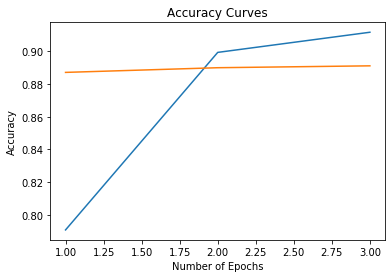

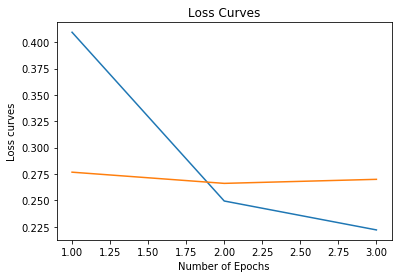

In [0]:
model3_64_history = model3_64.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation), 
                            batch_size=128, use_multiprocessing=True, callbacks = [EarlyStopping(monitor='val_loss', patience=1)])
plot_metrics(model3_64_history, len(model3_64_history.history["val_loss"]))

In [0]:
y_pred3_64 = np.round(model3_64.predict(X_test))
print("Accuracy", accuracy(y_test, y_pred3_64))
print("Precision (Safe)", precision(y_test, y_pred3_64, 0))
print("Precision (Unsafe)", precision(y_test, y_pred3_64, 1))
print("Recall (Safe)", recall(y_test, y_pred3_64, 0))
print("Recall (Unsafe)", recall(y_test, y_pred3_64, 1))


Accuracy [0.88899863]
Precision (Safe) [0.90706702]
Precision (Unsafe) [0.87227974]
Recall (Safe) [0.86792659]
Recall (Unsafe) [0.91026348]


## Model 4: Convolutional Neural Network with Two Convolutional Layers and Dropout

Create the third variation of the CNN. It is a sequential model with the following structure:
- Embedding layer that converts each integer sequence (previously a sentence) into a dense vector, which is easier for the model to use.
- Two One-Dimensional Convolutional layers with 64 filters, filter size of 3, and relu activation
- One-Dimensional Maximum Pooling layer
- Dropout layer with 0.15 dropout
- Flattening layer to convert the matrix of values to a single vector
- Dense layer with 1 output neuron and sigmoid activation to classify each sentence as either safe or unsafe

This model is built on top of model3, with 64 convolutional filters.

Dropout variations of 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, and 0.75 were explored. Ultimately, 0.15 provided the best result. This is the model that was shown.

Train the model for up to 10 epochs, with early stopping (patience of 1). Plot the accuracy and loss curves (training vs validation), and print the accuracy, precision, and recall.



In [0]:
model4_15 = Sequential()

model4_15.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length = max_len))
model4_15.add(Conv1D(64, 3, activation = "relu"))
model4_15.add(Conv1D(64, 3, activation = "relu"))
model4_15.add(MaxPooling1D())
model4_15.add(Dropout(0.15))
model4_15.add(Flatten())
model4_15.add(Dense(256, activation = "relu"))
model4_15.add(Dense(1, activation = "sigmoid"))

model4_15.compile(optimizer = optimizers.Adam(lr=0.0001), 
               loss = 'binary_crossentropy', 
               metrics = ['accuracy'])

model4_15.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 2321, 128)         24291328  
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 2319, 64)          24640     
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 2317, 64)          12352     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 1158, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1158, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 74112)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)              

Train on 328050 samples, validate on 18225 samples
Epoch 1/10
328050/328050 [==============================] - 152s 463us/step - loss: 0.4851 - acc: 0.7171 - val_loss: 0.2841 - val_acc: 0.8840
Epoch 2/10
328050/328050 [==============================] - 151s 462us/step - loss: 0.2581 - acc: 0.8954 - val_loss: 0.2662 - val_acc: 0.8908
Epoch 3/10
328050/328050 [==============================] - 150s 458us/step - loss: 0.2283 - acc: 0.9088 - val_loss: 0.2670 - val_acc: 0.8882


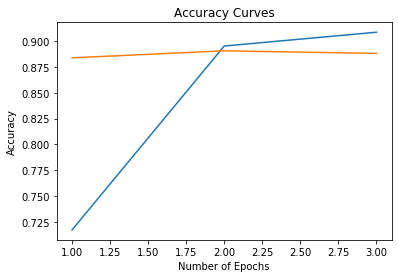

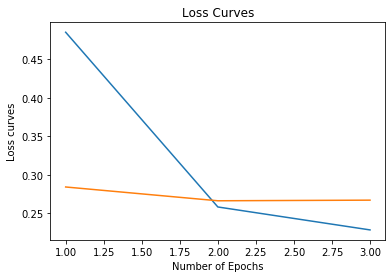

In [0]:
model4_15_history = model4_15.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation),
                            batch_size=128, use_multiprocessing=True, callbacks = [EarlyStopping(monitor='val_loss', patience=1)])
plot_metrics(model4_15_history, len(model4_15_history.history["val_loss"]))

In [0]:
y_pred4_15 = np.round(model4_15.predict(X_test))
print("Accuracy", accuracy(y_test, y_pred4_15))
print("Precision (Safe)", precision(y_test, y_pred4_15, 0))
print("Precision (Unsafe)", precision(y_test, y_pred4_15, 1))
print("Recall (Safe)", recall(y_test, y_pred4_15, 0))
print("Recall (Unsafe)", recall(y_test, y_pred4_15, 1))


Accuracy [0.89091907]
Precision (Safe) [0.90836563]
Precision (Unsafe) [0.87472225]
Recall (Safe) [0.87065764]
Recall (Unsafe) [0.91136589]


## Model 5: Convolutional Neural Network with Two Sets of Two Convolutional Layers

Create the fourth variation of the CNN. It is a sequential model with the following structure:
- Embedding layer that converts each integer sequence (previously a sentence) into a dense vector, which is easier for the model to use.
- Two One-Dimensional Convolutional layers with 32 filters, filter size of 3, and relu activation
- One-Dimensional Maximum Pooling layer
- Two One-Dimensional Convolutional layers with 64 filters, filter size of 3, and relu activation
- One-Dimensional Maximum Pooling layer
- Flattening layer to convert the matrix of values to a single vector
- Dense layer with 1 output neuron and sigmoid activation to classify each sentence as either safe or unsafe

The following convolutional filter combinations were explored (the first number is the number of filters in the first set of conv layers; the second number is the number of filters in the second set of conv layers): 16/32, 32/64, 16/128, 32/128, 64/128. Ultimately, 32/64 provided the best results, which is the model shown.

Train the model for up to 10 epochs, with early stopping (patience of 1). Plot the accuracy and loss curves (training vs validation), and print the accuracy, precision, and recall.



In [0]:
model5_3264 = Sequential()

model5_3264.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length = max_len))
model5_3264.add(Conv1D(32, 3, activation = "relu"))
model5_3264.add(Conv1D(32, 3, activation = "relu"))
model5_3264.add(MaxPooling1D())
model5_3264.add(Conv1D(64, 3, activation = "relu"))
model5_3264.add(Conv1D(64, 3, activation = "relu"))
model5_3264.add(MaxPooling1D())
model5_3264.add(Flatten())
model5_3264.add(Dense(256, activation = "relu"))
model5_3264.add(Dense(1, activation = "sigmoid"))

model5_3264.compile(optimizer = optimizers.Adam(lr=0.0001), 
               loss = 'binary_crossentropy', 
               metrics = ['accuracy'])

model5_3264.summary()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2321, 128)         24291328  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2319, 32)          12320     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2317, 32)          3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1158, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1156, 64)          6208      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1154, 64)          12352     
____________________

Train the model, using early stopping with validation loss and patience of 2 epochs




Train on 328050 samples, validate on 18225 samples
Epoch 1/10





328050/328050 [==============================] - 134s 410us/step - loss: 0.3866 - acc: 0.8095 - val_loss: 0.2711 - val_acc: 0.8900
Epoch 2/10
328050/328050 [==============================] - 127s 387us/step - loss: 0.2425 - acc: 0.9021 - val_loss: 0.2652 - val_acc: 0.8918
Epoch 3/10
328050/328050 [==============================] - 127s 386us/step - loss: 0.2105 - acc: 0.9171 - val_loss: 0.2798 - val_acc: 0.8889


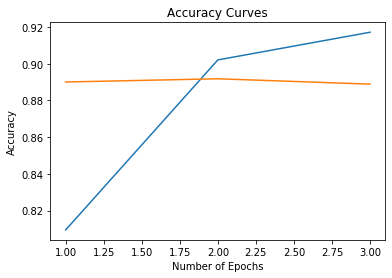

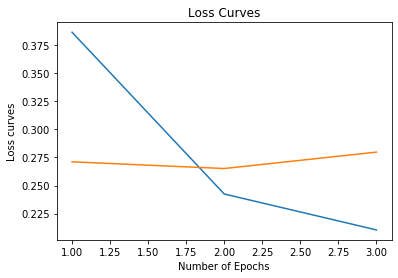

In [0]:
model5_3264_history = model5_3264.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation), 
                            batch_size=128, use_multiprocessing=True, callbacks = [EarlyStopping(monitor='val_loss', patience=1)])
plot_metrics(model5_3264_history, len(model5_3264_history.history["val_loss"]))

Test the model using the test set. Print the accuracy, as well as the recall and precision for both classes.

In [0]:
y_pred5_3264 = np.round(model5_3264.predict(X_test))
print("Accuracy", accuracy(y_test, y_pred5_3264))
print("Precision (Safe)", precision(y_test, y_pred5_3264, 0))
print("Precision (Unsafe)", precision(y_test, y_pred5_3264, 1))
print("Recall (Safe)", recall(y_test, y_pred5_3264, 0))
print("Recall (Unsafe)", recall(y_test, y_pred5_3264, 1))


Accuracy [0.88658436]
Precision (Safe) [0.89185005]
Precision (Unsafe) [0.88139839]
Recall (Safe) [0.88103561]
Recall (Unsafe) [0.89218388]


## Model 6: Convolutional Neural Network with Two Sets of Two Convolutional Layers with Dropout

Create the fifth and final variation of the CNN. It is a sequential model with the following structure:
- Embedding layer that converts each integer sequence (previously a sentence) into a dense vector, which is easier for the model to use.
- Two One-Dimensional Convolutional layers with 32 filters, filter size of 3, and relu activation
- One-Dimensional Maximum Pooling layer
- Dropout layer with 0.75 dropout
- Two One-Dimensional Convolutional layers with 64 filters, filter size of 3, and relu activation
- One-Dimensional Maximum Pooling layer
- Dropout layer with 0.75 dropout
- Flattening layer to convert the matrix of values to a single vector
- Dense layer with 1 output neuron and sigmoid activation to classify each sentence as either safe or unsafe

Dropout variations of 0.1, 0.15, 0.2, 0.25, 0.5, 0.7, 0.75, 0.8, and 0.9 were explore. Ulimately, 0.75 provided the best result and this is the model that is shown.

Train the model for up to 10 epochs, with early stopping (patience of 1). Plot the accuracy and loss curves (training vs validation), and print the accuracy, precision, and recall.



In [0]:
model6_3264_drop = Sequential()

model6_3264_drop.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length = max_len))
model6_3264_drop.add(Conv1D(32, 3, activation = "relu"))
model6_3264_drop.add(Conv1D(32, 3, activation = "relu"))
model6_3264_drop.add(MaxPooling1D())
model6_3264_drop.add(Dropout(0.15))
model6_3264_drop.add(Conv1D(64, 3, activation = "relu"))
model6_3264_drop.add(Conv1D(64, 3, activation = "relu"))
model6_3264_drop.add(MaxPooling1D())
model6_3264_drop.add(Dropout(0.15))
model6_3264_drop.add(Flatten())
model6_3264_drop.add(Dense(256, activation = "relu"))
model6_3264_drop.add(Dense(1, activation = "sigmoid"))

model6_3264_drop.compile(optimizer = optimizers.Adam(lr=0.0001), 
               loss = 'binary_crossentropy', 
               metrics = ['accuracy'])

model6_3264_drop.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 2321, 128)         24291328  
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 2319, 32)          12320     
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 2317, 32)          3104      
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 1158, 32)          0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 1158, 32)          0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 1156, 64)          6208      
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 1154, 64)        

Train on 328050 samples, validate on 18225 samples
Epoch 1/10
328050/328050 [==============================] - 141s 429us/step - loss: 0.3992 - acc: 0.8017 - val_loss: 0.2756 - val_acc: 0.8876
Epoch 2/10
328050/328050 [==============================] - 137s 418us/step - loss: 0.2467 - acc: 0.9008 - val_loss: 0.2678 - val_acc: 0.8906
Epoch 3/10
328050/328050 [==============================] - 137s 419us/step - loss: 0.2140 - acc: 0.9152 - val_loss: 0.2727 - val_acc: 0.8908


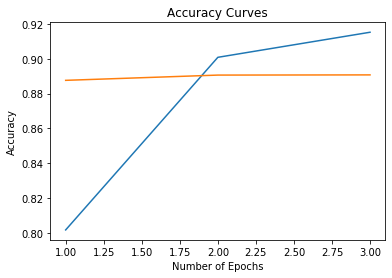

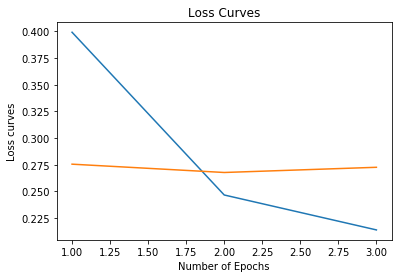

In [0]:
model6_3264_drop_history = model6_3264_drop.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation), 
                            batch_size=128, use_multiprocessing=True, callbacks = [EarlyStopping(monitor='val_loss', patience=1)])
plot_metrics(model6_3264_drop_history, len(model6_3264_drop_history.history["val_loss"]))

In [0]:
y_pred6_3264_drop = np.round(model6_3264_drop.predict(X_test))
print("Accuracy", accuracy(y_test, y_pred6_3264_drop))
print("Precision (Safe)", precision(y_test, y_pred6_3264_drop, 0))
print("Precision (Unsafe)", precision(y_test, y_pred6_3264_drop, 1))
print("Recall (Safe)", recall(y_test, y_pred6_3264_drop, 0))
print("Recall (Unsafe)", recall(y_test, y_pred6_3264_drop, 1))


Accuracy [0.88828532]
Precision (Safe) [0.90767468]
Precision (Unsafe) [0.87045814]
Recall (Safe) [0.86563251]
Recall (Unsafe) [0.91114541]
